# Dense Sentiment Classifier

Classify IMDB reviews by their sentiment

In [4]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Set hyperparameters

In [5]:
output_dir = 'model_output/dense'

epochs = 4
batch_size = 128

n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50
max_review_length = 100
pad_type = trunc_type = 'pre'

n_dense = 64
dropout = 0.5


#### Load data

In [37]:
(x_train, y_train) , (x_valid, y_valid) = imdb.load_data(num_words = n_unique_words ,skip_top = n_words_to_skip )

In [38]:
#len(x_train[0])
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [39]:
# 0 for padding (short reviews padded by zeros)
# 1 for starting characters
# 2 unknown token
# 3 ,4 ,....most frequent words

In [40]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [41]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0], dtype=int64)

In [42]:
# 1 for positive
# 0 for negative

In [43]:
len(x_train),len(x_valid)

(25000, 25000)

#### Restore words from index

In [44]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index['PAD'] = 0
word_index['START'] = 1
word_index['UNK'] = 2

In [45]:
# word_index

In [46]:
index_word = {v:k for k,v in word_index.items()}

In [47]:
# x_train[0]

In [48]:
# ' '.join(index_word[id] for id in x_train[0])
#show words with indexes substituted

In [49]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data()

In [50]:
# ' '.join(index_word[id] for id in all_x_train[0])
#show original view with words substituted

#### Preprocess data

In [52]:
x_train[5],len(x_train[5])

([2,
  778,
  128,
  74,
  2,
  630,
  163,
  2,
  2,
  1766,
  2,
  1051,
  2,
  2,
  85,
  156,
  2,
  2,
  148,
  139,
  121,
  664,
  665,
  2,
  2,
  1361,
  173,
  2,
  749,
  2,
  2,
  3804,
  2,
  2,
  226,
  65,
  2,
  2,
  127,
  2,
  2,
  2,
  2],
 43)

In [53]:
x_train = pad_sequences(x_train,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)
x_valid = pad_sequences(x_valid,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)

In [54]:
for x in x_train[0:6]:
    print(len(x))
# for this method all lengths should be the same!    

100
100
100
100
100
100


In [56]:
x_train[5]
#check the differences and how their size is being same?

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    2,  778,  128,   74,    2,  630,  163,    2,    2,
       1766,    2, 1051,    2,    2,   85,  156,    2,    2,  148,  139,
        121,  664,  665,    2,    2, 1361,  173,    2,  749,    2,    2,
       3804,    2,    2,  226,   65,    2,    2,  127,    2,    2,    2,
          2])

In [57]:
' '.join(index_word[id] for id in x_train[0])


"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [58]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Design NN architecture

In [64]:
model = Sequential()
model.add(Embedding(n_unique_words,n_dim,input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1,activation='sigmoid'))

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [66]:
n_dim,n_unique_words,n_dim*n_unique_words

(64, 5000, 320000)

In [67]:
max_review_length,n_dim,n_dim*max_review_length

(100, 64, 6400)

In [68]:
n_dense,n_dim*max_review_length*n_dense + n_dense

(64, 409664)

In [69]:
n_dense +1 

65

#### Configure model

In [70]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [76]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

In [77]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [78]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 7s 270us/step - loss: 0.0061 - acc: 0.9998 - val_loss: 0.6094 - val_acc: 0.8344
Epoch 2/4
25000/25000 [==============================] - 7s 265us/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.6647 - val_acc: 0.8350
Epoch 3/4
25000/25000 [==============================] - 6s 260us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.7005 - val_acc: 0.8364
Epoch 4/4
25000/25000 [==============================] - 6s 258us/step - loss: 9.0611e-04 - acc: 1.0000 - val_loss: 0.7331 - val_acc: 0.8362


#### Evaluate

In [79]:
model.load_weights(output_dir+'/weights.03.hdf5')

In [80]:
y_hat = model.predict_proba(x_valid)

In [81]:
y_hat[0]

array([0.00641614], dtype=float32)

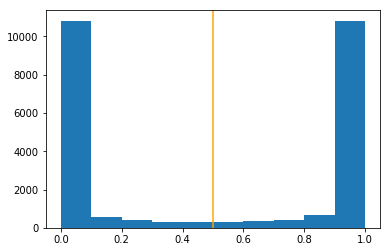

In [82]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5,color='orange')

In [88]:
pct_auc = roc_auc_score(y_valid,y_hat)*100.0

In [89]:
"{:0.2f}".format(pct_auc)

'91.90'

In [90]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [92]:
ydf = pd.DataFrame(list(zip(float_y_hat,y_valid)),columns=['y_hat','y'])

In [93]:
ydf.head()

,y_hat,y
0,0.006416,0
1,0.999998,1
2,0.999814,1
3,0.034572,0
4,1.000000,1


In [94]:
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [95]:
' '.join(index_word[id] for id in all_x_valid[4])

"START like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and exiting they will hook you 'till your mind turns to mush i'm not kidding this game is also orchestrated and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good hardness 10 attention grabber 10 average 10"

In [98]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
17,0.990501,0
75,0.999749,0
112,0.943058,0
115,0.998187,0
152,0.999990,0
156,0.999124,0
232,0.916796,0
247,0.979242,0
256,0.997409,0
260,0.944765,0


In [100]:
' '.join(index_word[id] for id in all_x_valid[152])

"START i can pretend no knowledge of cinematography or mr angelopoulos but i know greece and i love her people in july my 14 year old son and i traveled to turkey in search of some remains of the neighborhood where his great grandfather lived until the great exodus of greeks in 1923 reading the summary of the film refugees from odessa i thought that perhaps i might learn something more about the forced migrations of modern greeks if i did not have a home in rhodes had i not been to greece 28 times in as many years were i not familiar with dozens of islands and cities in greece and if i had never enjoyed the friendship of these ebullient life intoxicated people i might have believed that this had something to do with modern greece as a professor at a new jersey state college let me assure you that i am familiar with the history of the period covered in the film indeed my wife's uncle was murdered by the communists during the communist grab for power my mother in law lived through the it

In [101]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
22,0.000197,1
45,0.000032,1
80,0.000551,1
82,0.083923,1
100,0.000030,1
101,0.000244,1
134,0.014414,1
159,0.042876,1
167,0.000178,1
187,0.000537,1


In [103]:
' '.join(index_word[id] for id in all_x_valid[45])

"START the above profile was written by me when i used the nick of which is still my email address i still believe andy devine's character of frisky is the best twilight episodes ever and i watch this episode at least once a year as i consider to be a fortunate man as he has many friends who love him dearly br br in case many of you are too young to remember i'm 61 andy devine hosted a children's entertainment show in the 50's i believe called andy's gang on it he had three assistants a cat named midnight who played the violin a mouse named squeaky who played an a hand organ and a devilish toad named who's could appear and disappear at will embarrassing many of andy's funny guest stars like billy gilbert"